# A rotating mesh with pulsations

In [2]:
from spice.models import IcosphereModel
from spice.models.mesh_transform import add_rotation, evaluate_rotation, add_pulsation, evaluate_pulsations
from spice.plots import plot_3D_mesh_and_spectrum
from spice.spectrum import simulate_spectrum
import astropy.units as u
import jax
import jax.numpy as jnp
import numpy as np
from transformer_payne import Blackbody

from jax import config
config.update('jax_platform_name', 'cpu')
config.update("jax_enable_x64", True)

Let's use the simplest example for the sake of speed - the blackbody flux from the ```transformer_payne``` package.

In [3]:
bb = Blackbody()

The API is in the functional paradigm - you pass a "model" mesh, and the function returns a modified version of the mesh. However, the original passed mesh still remains if you choose not to overwrite these variables.

In [58]:
base_temp = 5700

m = IcosphereModel.construct(1000, u.solRad.to(u.cm), 1., 1., bb.to_parameters(dict(teff=base_temp)))

m = add_pulsation(m, jnp.array([0, 0]), jnp.array([1., 1.]), jnp.array([[1e-4, 0.]]))

In [59]:
TIMESTAMPS = jnp.linspace(0, 10., 100)

In [60]:
from spice.plots import plot_3D_sequence
mps = [evaluate_pulsations(m, t) for t in TIMESTAMPS]

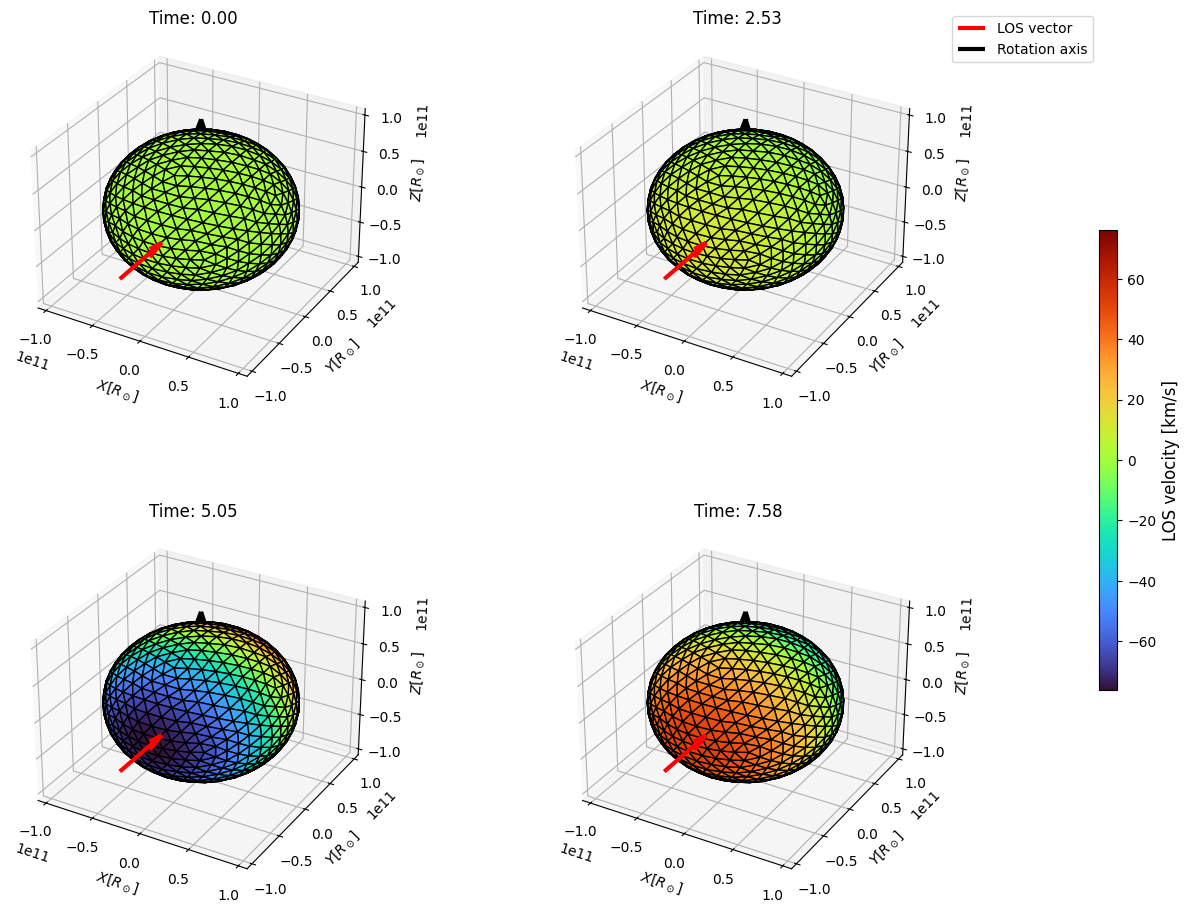

In [61]:
_, _, _ = plot_3D_sequence(mps[::25], 'los_velocities', TIMESTAMPS[::25])

## Spectrum emulation

In [62]:
vws = jnp.linspace(100., 12000., 1000)
specs = [simulate_spectrum(bb.intensity, mp0, jnp.log10(vws)) for mp0 in mps]

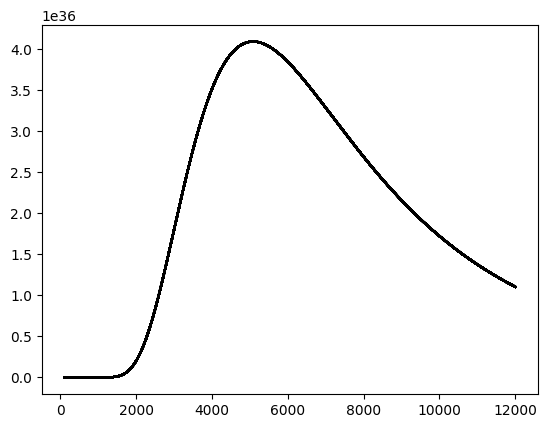

In [63]:
import matplotlib.pyplot as plt

for spec in specs:
    plt.plot(vws, spec, color='black', alpha=0.5)

(<Figure size 2400x1000 with 3 Axes>,
 <Axes3D: xlabel='$X [R_\\odot]$', ylabel='$Y [R_\\odot]$', zlabel='$Z [R_\\odot]$'>,
 <Axes: xlabel='wavelength [$\\AA$]', ylabel='intensity [erg/s/cm$^2$]'>)

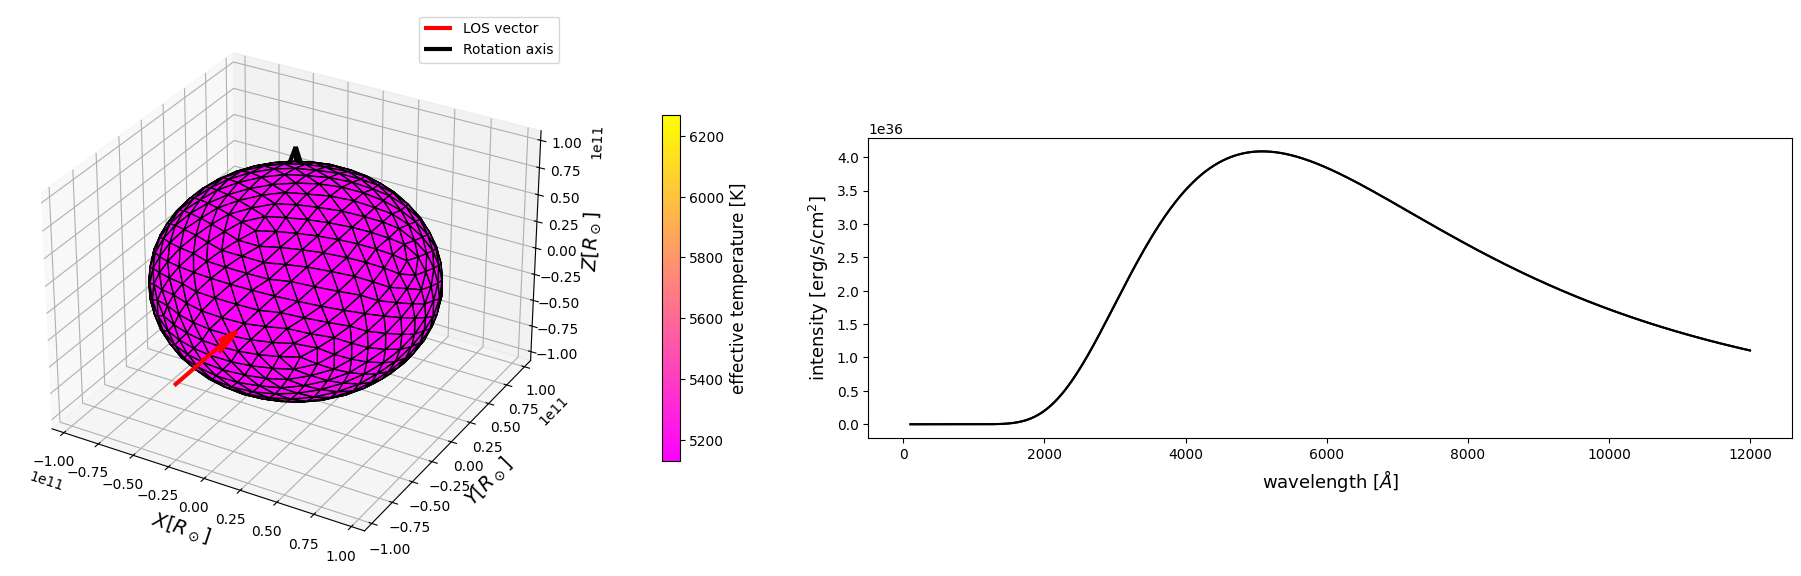

In [64]:
time_idx = 3
plot_3D_mesh_and_spectrum(mps[time_idx], vws, specs[time_idx], dict(property=0, cmap='spring', property_label='effective temperature [K]'))

(<Figure size 2400x1000 with 3 Axes>,
 <Axes3D: xlabel='$X [R_\\odot]$', ylabel='$Y [R_\\odot]$', zlabel='$Z [R_\\odot]$'>,
 <Axes: xlabel='wavelength [$\\AA$]', ylabel='intensity [erg/s/cm$^2$]'>)

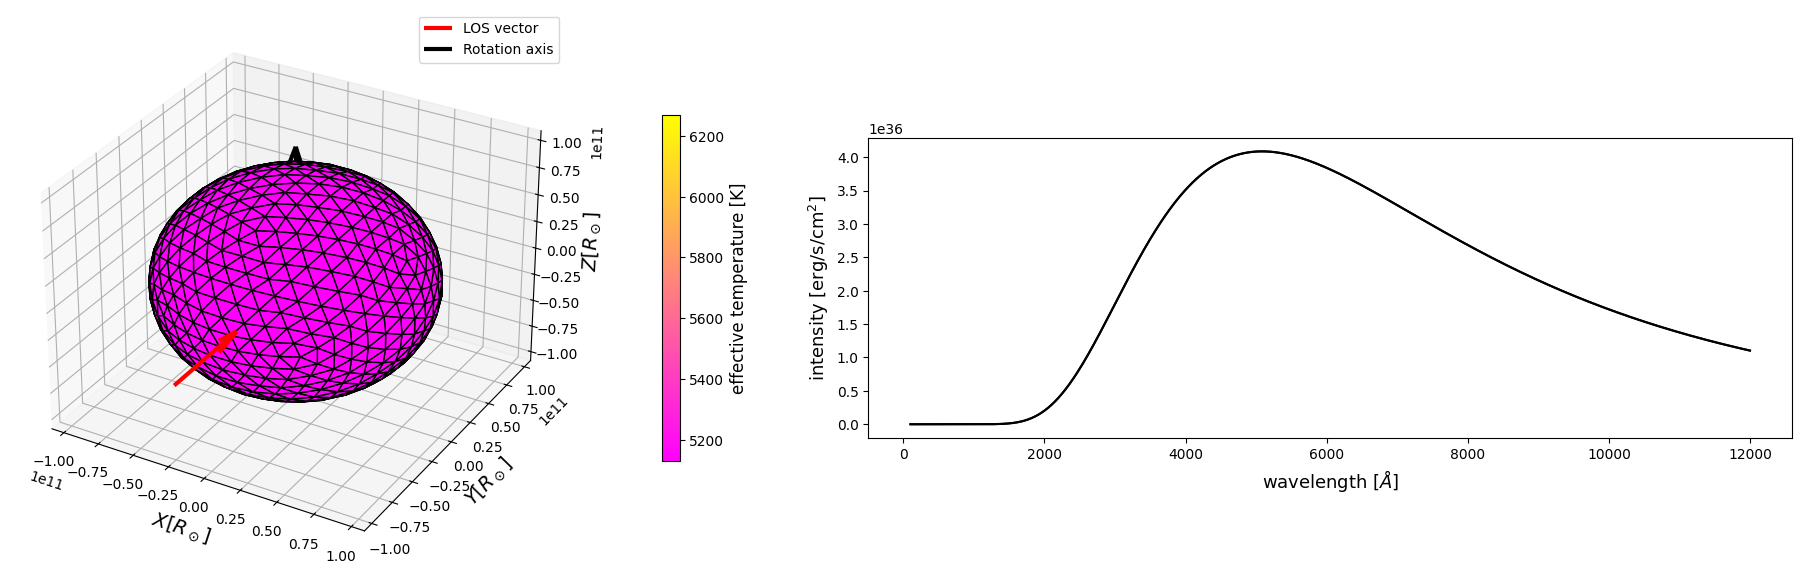

In [65]:
time_idx = 0
plot_3D_mesh_and_spectrum(mps[time_idx], vws, specs[time_idx], dict(property=0, cmap='spring', property_label='effective temperature [K]'))

## Photometric time series

In [66]:
from spice.spectrum.filter import BesselU, BesselB, BesselV
from spice.spectrum.spectrum import AB_passband_luminosity

In [67]:
bessel_B = BesselB()
bessel_U = BesselU()
bessel_V = BesselV()

In [68]:
d = u.AU.to(u.cm)
U_phot = np.array([AB_passband_luminosity(bessel_U, vws, flux[:, 0], distance=d) for flux in specs])
B_phot = np.array([AB_passband_luminosity(bessel_B, vws, flux[:, 0], distance=d) for flux in specs])
V_phot = np.array([AB_passband_luminosity(bessel_V, vws, flux[:, 0], distance=d) for flux in specs])

# Calculate color indices
U_B = U_phot - B_phot
B_V = B_phot - V_phot


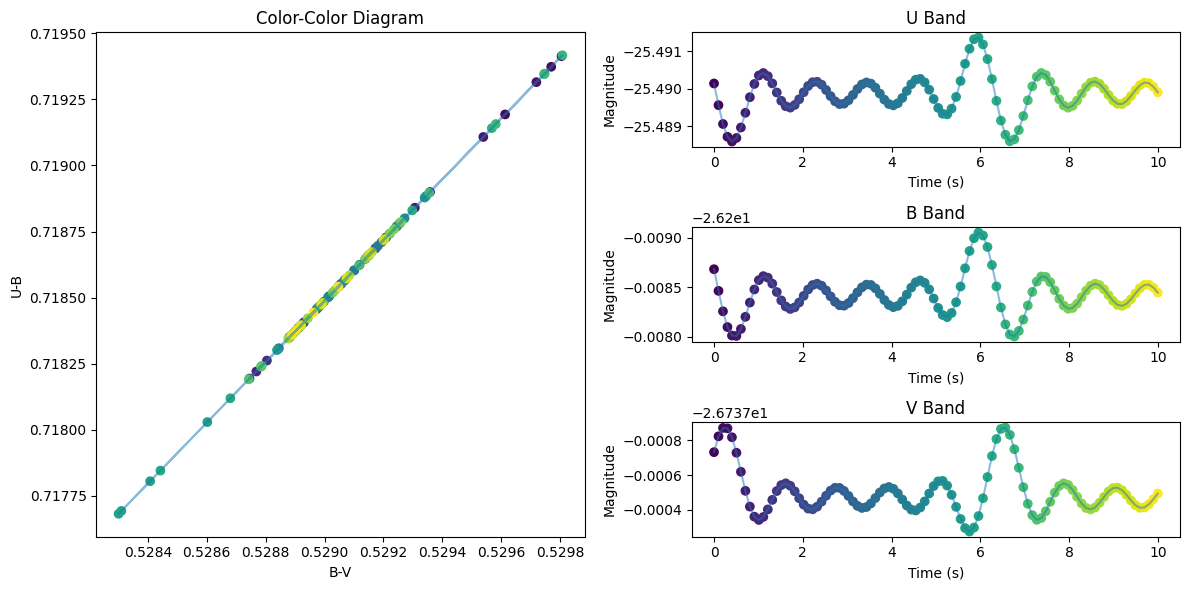

In [69]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(3, 2, figure=fig)

# Plot color-color diagram
ax_color = fig.add_subplot(gs[:, 0])
ax_color.plot(B_V, U_B, alpha=0.5)
ax_color.scatter(B_V, U_B, c=TIMESTAMPS, cmap='viridis')
ax_color.set_xlabel('B-V')
ax_color.set_ylabel('U-B')
ax_color.set_title('Color-Color Diagram')

# Photometry data and labels for loop
phot_data = [U_phot, B_phot, V_phot]
labels = ['U Band', 'B Band', 'V Band']

# Create photometry magnitude time series plots
for i, (data, label) in enumerate(zip(phot_data, labels)):
    ax = fig.add_subplot(gs[i, 1])
    ax.plot(TIMESTAMPS, data, label=label, alpha=0.5)
    ax.scatter(TIMESTAMPS, data, c=TIMESTAMPS, cmap='viridis', label='Markers')

    ax.set_title(label)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Magnitude')
    ax.invert_yaxis()

plt.tight_layout()